In [114]:
library(caret)
library(keras)
library(nnet)

# Simulate Data

In [115]:
set.seed(1234)

#Create data set
data_set <- twoClassSim(20000,
                        intercept = -6,
                        linearVars = 8,
                        noiseVars = 8)


#Create train/tests sets
index <- createDataPartition(data_set$Class, p = .5, list=FALSE)

train_set <- data_set[index,]
test_set <- data_set[-index,]

In [116]:
#Dependent / Independent Variables
Y <-'Class'
X <-names(train_set)[!names(train_set) %in% Y]

# RF

In [117]:
ctrl <- trainControl(method = "repeatedcv",
                     number = 4,
                     repeats = 2,
                     classProbs = TRUE)

tune_g <- data.frame(mtry = c(3,6,9,12))

cv_rftrain <- train(x=data_set[,X],
                 y=data_set[,Y],
                 method = "rf",
                 verbose = FALSE,
                 trControl = ctrl,
                 tuneGrid = tune_g,
                 allowParallel=TRUE)

cv_rftrain

Random Forest 

20000 samples
   21 predictor
    2 classes: 'Class1', 'Class2' 

No pre-processing
Resampling: Cross-Validated (4 fold, repeated 2 times) 
Summary of sample sizes: 15001, 14999, 15000, 15000, 15000, 14999, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   3    0.8750000  0.7369859
   6    0.8832249  0.7557457
   9    0.8852248  0.7604558
  12    0.8846247  0.7593453

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 9.

# NNET

In [118]:
ctrl <- trainControl(method = "repeatedcv",
                     number = 4,
                     repeats = 2,
                     classProbs = TRUE)

tune_g <- expand.grid(size = c(4,16,32),
                    decay  = c(0,.01,.001,.0001))


model_nnet <- train(train_set[,X],
                  train_set[,Y],
                  method='nnet',
                  trace = FALSE,
                  tuneGrid = tune_g,  
                  trControl = ctrl)

model_nnet

Neural Network 

10000 samples
   21 predictor
    2 classes: 'Class1', 'Class2' 

No pre-processing
Resampling: Cross-Validated (4 fold, repeated 2 times) 
Summary of sample sizes: 7500, 7501, 7499, 7500, 7500, 7501, ... 
Resampling results across tuning parameters:

  size  decay  Accuracy   Kappa    
   4    0e+00  0.9075506  0.8082853
   4    1e-04  0.9085497  0.8105479
   4    1e-03  0.9056501  0.8044078
   4    1e-02  0.9078000  0.8088829
  16    0e+00  0.8969502  0.7865945
  16    1e-04  0.8966001  0.7860403
  16    1e-03  0.8915497  0.7754655
  16    1e-02  0.8965502  0.7860122
  32    0e+00  0.8708504  0.7329592
  32    1e-04  0.8723500  0.7360087
  32    1e-03  0.8731498  0.7374665
  32    1e-02  0.8747498  0.7410184

Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were size = 4 and decay = 1e-04.

# Keras

In [119]:
#Build Keras Model
model_keras <- keras_model_sequential()

#Set up Y vector
y_train_vec <- ifelse(train_set[,Y]  == "Class2", 1, 0)

model_keras <- model_keras %>% 
  
  # First hidden layer
  layer_dense(
    units              = 16, 
    kernel_initializer = "uniform", 
    activation         = "relu", 
    input_shape        = ncol( train_set[,X] )) %>% 
  
  # Dropout to prevent overfitting
  layer_dropout(rate = 0.1) %>%
  
  # Second hidden layer
  layer_dense(
    units              = 16, 
    kernel_initializer = "uniform", 
    activation         = "relu") %>% 
  
  # Dropout to prevent overfitting
  layer_dropout(rate = 0.1) %>%



  # Third hidden layer
  layer_dense(
    units              = 16, 
    kernel_initializer = "uniform", 
    activation         = "relu") %>% 
  
  # Dropout to prevent overfitting
  layer_dropout(rate = 0.1) %>%
  
  # Output layer
  layer_dense(
    units              = 1, 
    kernel_initializer = "uniform", 
    activation         = "sigmoid") %>% 
  
  # Compile ANN
  compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy',
    metrics   = c('accuracy')
  )

In [120]:
history <- fit(
  object           = model_keras, 
  x                = as.matrix( train_set[,X] ), 
  y                = as.matrix( y_train_vec ),
  batch_size       = 50, 
  epochs           = 50,
  validation_split = 0.30
)

In [121]:
print(history)

Trained on 7,000 samples, validated on 3,000 samples (batch_size=50, epochs=50)
Final epoch (plot to see history):
val_loss: 0.1988
 val_acc: 0.9193
    loss: 0.2012
     acc: 0.9151 


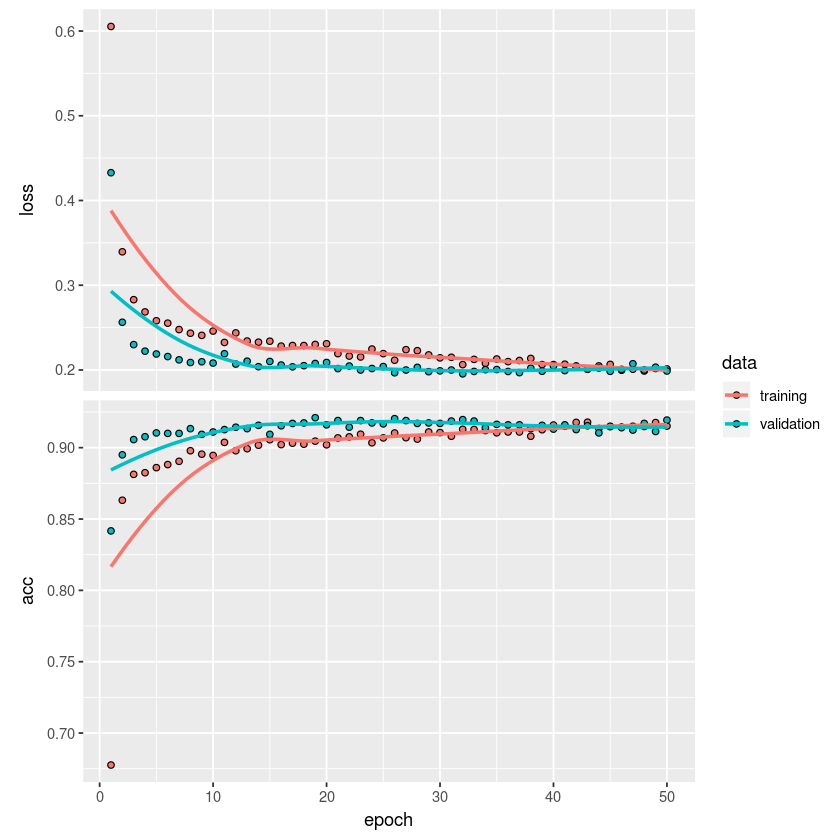

In [122]:
plot(history)

# Compare

In [123]:
require(PRROC)

In [124]:
rf_prob <- predict(cv_rftrain, test_set[,X], type="prob")$Class2

nn_prob <- predict(model_nnet, test_set[,X], type="prob")$Class2

keras_prob  <- predict_proba(object = model_keras, x = as.matrix(test_set[,X])) %>%
    as.vector()

In [132]:
class2 <- rf_prob[test_set[,Y] == 'Class2']
class1 <- rf_prob[test_set[,Y] == 'Class1']

#Curve
pr <- pr.curve(scores.class0 = class2, scores.class1 = class1)
pr

roc <- roc.curve(scores.class0 = class2, scores.class1 = class1)
roc


mean((rf_prob > .65 & test_set[,Y] == 'Class2') | (rf_prob <= .65 & test_set[,Y] != 'Class2') )


  Precision-recall curve

    Area under curve (Integral):
     1 

    Area under curve (Davis & Goadrich):
     1 

    Curve not computed ( can be done by using curve=TRUE )


  ROC curve

    Area under curve:
     1 

    Curve not computed ( can be done by using curve=TRUE )

[1] 0.9999

In [126]:
class2 <- nn_prob[test_set[,Y] == 'Class2']
class1 <- nn_prob[test_set[,Y] == 'Class1']

#Curve
pr <- pr.curve(scores.class0 = class2, scores.class1 = class1)
pr

roc <- roc.curve(scores.class0 = class2, scores.class1 = class1)
roc

mean((nn_prob > .5 & test_set[,Y] == 'Class2') | (nn_prob <= .5 & test_set[,Y] != 'Class2') )


  Precision-recall curve

    Area under curve (Integral):
     0.9616792 

    Area under curve (Davis & Goadrich):
     0.9616792 

    Curve not computed ( can be done by using curve=TRUE )


  ROC curve

    Area under curve:
     0.9727954 

    Curve not computed ( can be done by using curve=TRUE )

[1] 0.9136

In [127]:
class2 <- keras_prob[test_set[,Y] == 'Class2']
class1 <- keras_prob[test_set[,Y] == 'Class1']

#Curve
pr <- pr.curve(scores.class0 = class2, scores.class1 = class1)
pr

roc <- roc.curve(scores.class0 = class2, scores.class1 = class1)
roc

mean((keras_prob > .5 & test_set[,Y] == 'Class2') | (keras_prob <= .5 & test_set[,Y] != 'Class2') )


  Precision-recall curve

    Area under curve (Integral):
     0.9673916 

    Area under curve (Davis & Goadrich):
     0.9673916 

    Curve not computed ( can be done by using curve=TRUE )


  ROC curve

    Area under curve:
     0.9756814 

    Curve not computed ( can be done by using curve=TRUE )

[1] 0.918